I implemented both CNNs on Colab and Python IDE PyCharm, because they both have pros and cons in terms of speeds, compability, usability and so on. I personally found Colab very friendly and easy to use, although is not as complete as PyCharm or Spider, in addition is usefull to run the training process here, save the weights and move back to local IDE.
Also the idea of suddenly being cut off from GPU usage is not very relaxing, espacially when you are experimenting and developing. I will use Colab as display for the dataset, and PyCharm as a final test to test the prediction. Althought they are both fully capable of running, training etc. EXCEPT FOR CUSTOM TESTING FOR NOW.

##Libraries

In [12]:
from google.colab import drive
import os, sys
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
# import warnings
# warnings.filterwarnings("ignore")
import seaborn as sb
import numpy as np
from IPython.display import Image
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.models import model_from_json

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


##Dataset

In [3]:
data = pd.read_csv('/content/drive/MyDrive/AI_Final/fer2013-project/fer2013.csv')
print(data.shape)
data.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


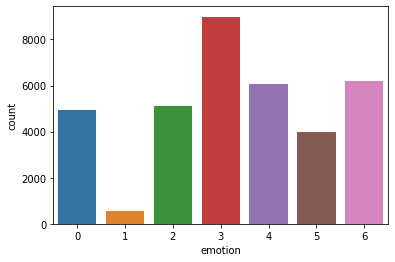

In [5]:
sb.countplot(data.emotion)
plt.show()

In [6]:
width, height = 48, 48

datapoints = data['pixels'].tolist()

# getting features for training
X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
# add an additional dimension to our feature vector by using
X = np.expand_dims(X, -1)

# this is done to make the input suitable for our CNN

# getting labels for training
y = pd.get_dummies(data['emotion']).values

# storing them using numpy
np.save('fdataX', X)
np.save('flabels', y)

print("Preprocessing Done")
print("Number of Features: "+str(len(X[0])))
print("Number of Labels: "+ str(len(y[0])))
print("Number of examples in dataset:"+str(len(X)))
print("X,y stored in fdataX.npy and flabels.npy respectively")

Preprocessing Done
Number of Features: 48
Number of Labels: 7
Number of examples in dataset:35887
X,y stored in fdataX.npy and flabels.npy respectively


In [7]:
num_features = 64
num_labels = 7
batch_size = 32
epochs = 100
width, height = 48, 48

x = np.load('fdataX.npy')
y = np.load('flabels.npy')

# standardized x by subtracting the means and
# dividing by the standard deviation.
x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

# I commented this visualization because I prefer to use the following, which is
# more clear and accurate, feel free to uncomment
# for xx in range(10): 
#    plt.figure(xx)
#    plt.imshow(x[xx].reshape((48, 48)), interpolation='none', cmap='gray')
# plt.show()

# we divide the data into training and testing set by using sklearn’s
# splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

# saving the test samples to be used later
np.save('modXtest', X_test)
np.save('modytest', y_test)

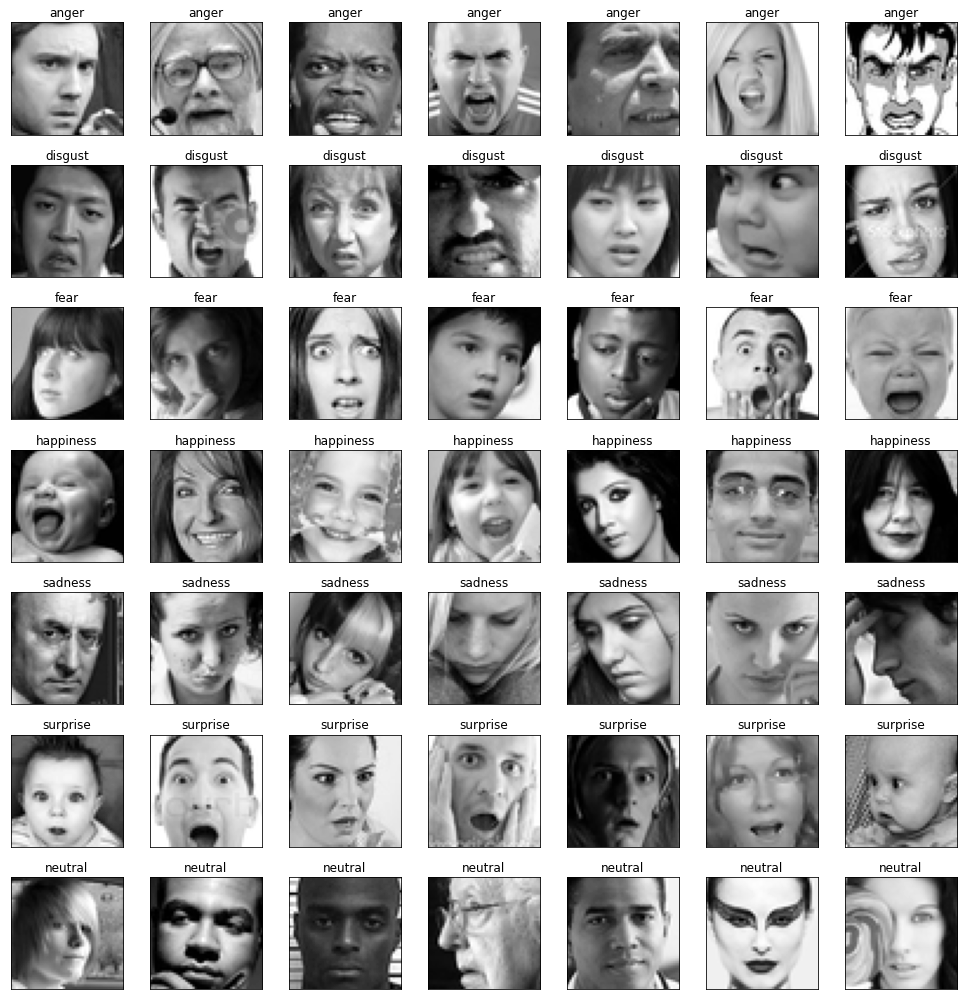

In [8]:
img = plt.figure(1, (14, 14))
emotion_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

dd = 0
for label in sorted(data.emotion.unique()):
    for j in range(7):
        pxl = data[data.emotion==label].pixels.iloc[dd]
        pxl = np.array(pxl.split(' ')).reshape(48, 48).astype('float32')

        dd += 1
        k = plt.subplot(7, 7, dd)
        k.imshow(pxl, cmap='gray')
        k.set_xticks([])
        k.set_yticks([])
        k.set_title(emotion_labels[label])
        plt.tight_layout()

##Model

In [9]:
# designing the CNN
# A sequential model is just a linear stack of layers which is putting layers
# on top of each other as we progress from the input layer to the output layer.
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1),
                 data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())  # on inputs to the next layer so that we have
# our inputs in a specified scale, say 0 to 1 instead of being scattered all over the place.
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2 * 64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2 * 64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2 * 2 * 64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2 * 2 * 64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2 * 2 * 2 * 64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2 * 2 * 2 * 64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2 * 2 * 2 * 64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2 * 2 * 64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2 * 64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

In [ ]:
model.summary()

In [10]:
# Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Save a png of the model structure.

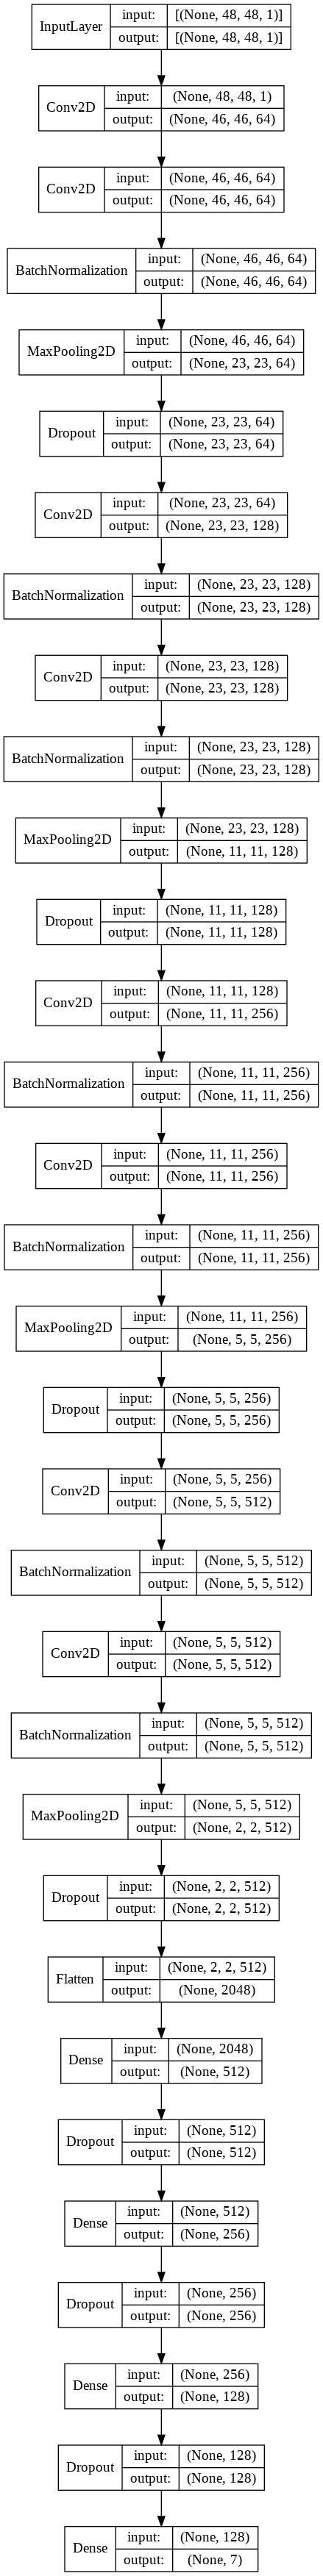

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)
Image('model.png',width=200, height=600)

##Training

In [13]:
# Data Augmentation
train_datagen = ImageDataGenerator(rotation_range=15,
                                   horizontal_flip=True,
                                   zoom_range=0.10
                                   width_shift_range=0.20,
                                   height_shift_range=0.20,
                                   shear_range=0.15)                                    )
train_datagen.fit(X_train)

In [14]:
# training the model
history = model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)

Epoch 1/100
909/909 [==============================] - 67s 62ms/step - loss: 1.9660 - accuracy: 0.2243 - val_loss: 1.8112 - val_accuracy: 0.2585
Epoch 2/100
909/909 [==============================] - 55s 60ms/step - loss: 1.8101 - accuracy: 0.2596 - val_loss: 1.6964 - val_accuracy: 0.3111
Epoch 3/100
909/909 [==============================] - 55s 60ms/step - loss: 1.6976 - accuracy: 0.3118 - val_loss: 1.5192 - val_accuracy: 0.3913
Epoch 4/100
909/909 [==============================] - 55s 60ms/step - loss: 1.5809 - accuracy: 0.3742 - val_loss: 1.4928 - val_accuracy: 0.3963
Epoch 5/100
909/909 [==============================] - 55s 60ms/step - loss: 1.5040 - accuracy: 0.4098 - val_loss: 1.4314 - val_accuracy: 0.4161
Epoch 6/100
909/909 [==============================] - 55s 60ms/step - loss: 1.4470 - accuracy: 0.4402 - val_loss: 1.3427 - val_accuracy: 0.4991
Epoch 7/100
909/909 [==============================] - 55s 60ms/step - loss: 1.4105 - accuracy: 0.4632 - val_loss: 1.2983 - val_ac

In [15]:
# saving the  model to be used later
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")

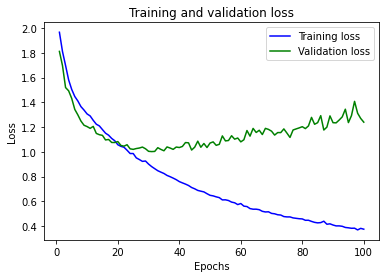

In [16]:
# plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

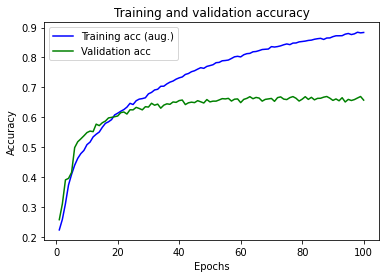

In [17]:
acc = history.history['accuracy']
# acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc (aug.)')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

##Load model w/out training


In [ ]:
from __future__ import division
from keras.models import model_from_json
json_file = open('/content/drive/MyDrive/AI_Final/fer2013-project/fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/AI_Final/fer2013-project/fer.h5")

##Testing model by running prediction

In [ ]:
truey = []
predy = []
x = np.load('./modXtest.npy')
y = np.load('./modytest.npy')

# yhat = model.predict(x)
yhat = loaded_model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if yh[i].index(yy) == yt[i].index(yyt):
        count += 1

acc = (count / len(y)) * 100

# saving values for confusion matrix and analysis
np.save('truey', truey)
np.save('predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set :" + str(acc) + "%")

Predicted and true label values saved
Accuracy on test set :66.25801058790749%


##Confusion Matrix Visualization

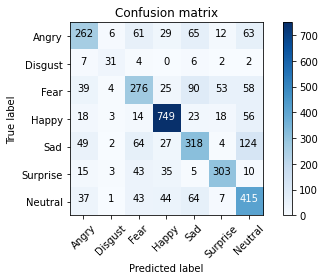

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

y_true = np.load('./truey.npy')
y_pred = np.load('./predy.npy')
cm = confusion_matrix(y_true, y_pred)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
title='Confusion matrix'
# print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

##Custom Testing

Please, use the Py file provided testcustom.py for testing, as this part needs debugging.


In [ ]:
# Custom Testing
import cv2
from google.colab.patches import cv2_imshow
# setting image resizing parameters
WIDTH = 48
HEIGHT = 48
x = None
y = None
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# loading image
dir_file_path = '/content/drive/MyDrive/AI_Final/fer2013-project/Expressions/'
file_path = dir_file_path + 'anger.jpg'
file_path2 = dir_file_path + 'surprise.png'
full_size_image = cv2.imread(file_path)

print("Image Loaded")
gray = cv2.cvtColor(full_size_image, cv2.COLOR_RGB2GRAY)
face = cv2.CascadeClassifier('/content/drive/MyDrive/AI_Final/fer2013-project/haarcascade_frontalface_default.xml')
faces = face.detectMultiScale(gray, 1.3, 10)

# detecting faces
for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        cv2.rectangle(full_size_image, (x, y), (x + w, y + h), (0, 255, 0), 1)

        #predicting the emotion
        # yhat= model.predict(cropped_img)
        yhat= loaded_model.predict(cropped_img)
        cv2.putText(full_size_image, labels[int(np.argmax(yhat))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)
        print("Emotion: "+labels[int(np.argmax(yhat))])

cv2_imshow('Emotion', full_size_image)
cv2.waitKey()

In [ ]:
def emotion_analysis(emotions):
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10, width=4, length=10)
    plt.xticks(y_pos, labels)
    plt.ylabel('percentage')
    plt.title('emotion')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


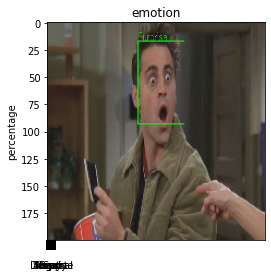

Expression Prediction: Neutral


In [ ]:
from skimage import io
img = image.load_img('/content/drive/MyDrive/AI_Final/fer2013-project/Expressions/surprise.png', grayscale=True, target_size=(48, 48))
show_img=image.load_img('/content/drive/MyDrive/AI_Final/fer2013-project/Expressions/surprise.png', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
# print(custom[0])
emotion_analysis(custom[0])


x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',labels[ind])
        